### Required Imports and Installations

In [1]:
#!pip install xgboost
#!pip install yellowbrick
#!pip install ipywidgets
#!pip install pandas-profiling

#!jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp

from scipy import stats
from scipy.stats import norm
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import xgboost
import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

%matplotlib inline

2022-05-22 02:48:43.199258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-22 02:48:43.199284: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data Ingestion & Pre-Processing

In [3]:
con_evs = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-EVs.sqlite"))
con_game = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Gaming.sqlite"))
con_oil = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Oil.sqlite"))
#con_tech = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Tech.sqlite"))
con_tech = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Tech2.sqlite"))
con_pnf = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-PnF.sqlite"))
#con_stock = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-stock.sqlite"))
con_stock = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb.sqlite"))
con_res = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results.sqlite"))
con_res2 = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results4.sqlite"))


cons = {
    "EVs": con_evs,
    "Gaming": con_game,
    "Oil": con_oil,
    "Tech": con_tech,
    "Pharma": con_pnf,
    "Food": con_pnf,
    "Stock": con_stock,
    "Results": con_res,
    "Results2": con_res2
}

In [4]:
tickers = {
    "EVs": ["TSLA", "LCID"],
    "Oil": ["COP", "XOM", "CVX"],
    "Pharma": ["PFE", "AZN", "MRNA"],
    "Food": ["MCD", "MDLZ", "PEP"],
    "Tech": ["GOOGL", "AAPL", "INTC", "MSFT"]
}

categories = ["EVs", "Oil", "Tech", "Pharma", "Food"]

#"Gaming": ["EA"]

#"Gaming": ["EA", "ATVI"],
#"Oil": ["COP", "XOM", "CVX", "ENB"],
#"Tech": ["GOOGL", "AAPL", "MSFT", "INTC"]

In [5]:
def load_datasets(cons, tickers, categories, reduce = False):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            if reduce == True:
                tweet_df = pd.read_sql_query(f"SELECT * from processed_tweets WHERE category='{category}'", cons["Results"])
                
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = -tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = -tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = -tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")
                
                tweet_df["neg_counts"] = -1 * tweet_df["neg_counts"]
                tweet_df["ind_neg"] = -1 * tweet_df["ind_neg"]
                tweet_df["wted_neg"] = -1 * tweet_df["wted_neg"]
                
                #tweet_df["mood"] = (tweet_df["pos_counts"] - tweet_df["neg_counts"]) / tweet_df["count"]

                tweet_df.sort_values(by=['date'])

                aggregate_dict = dict()

                for idx, row in tweet_df.iterrows():
                    key = f"{row['category']},{row['date']}"

                    if key in aggregate_dict:
                        aggregate_dict[key] = aggregate_dict[key] + row

                    else:
                        aggregate_dict[key] = row


                aggregate_dict_df = pd.DataFrame.from_dict(aggregate_dict, orient='index')   
                aggregate_dict_df.reset_index(drop=True, inplace=True)   
                aggregate_dict_df['date'] = aggregate_dict_df['date'].str.slice(0, 10)

                #print(aggregate_dict_df.head())

                aggregate_dict_df.drop(columns = ['category', 'ticker'], inplace=True)
                aggregate_dict_df["date"] = aggregate_dict_df["date"].astype("datetime64")

                tweet_dfs[ticker] = aggregate_dict_df.copy(deep=True)
                
            else:
                if category in ["Pharma", "Oil", "Tech", "EVs"]:    #use the new dataset results for Pharma ,Oil, Tech, EVs
                    #tweet_df = pd.read_sql_query(f"SELECT * from reduced_scored_tweets WHERE category='{category}'", cons["Results"])
                    tweet_df = pd.read_sql_query(f"SELECT * from reduced_tweet_counts WHERE category='{category}'", cons["Results2"])
                else:
                    tweet_df = pd.read_sql_query(f"SELECT * from new_scored_tweets WHERE category='{category}'", cons["Results"])

                tweet_df = tweet_df.drop(columns = ['category'])
                tweet_df["date"] = tweet_df["date"].astype("datetime64")
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")
                #tweet_df["mood"] = (tweet_df["wted_pos"] - tweet_df["wted_neg"]) / (tweet_df["wted_pos"] + tweet_df["wted_neu"] + tweet_df["wted_neg"])
                
                tweet_df["neg_counts"] = -1 * tweet_df["neg_counts"]
                tweet_df["ind_neg"] = -1 * tweet_df["ind_neg"]
                tweet_df["wted_neg"] = -1 * tweet_df["wted_neg"]
                
                tweet_dfs[ticker] = tweet_df.copy(deep=True)
            
            stock_df = pd.read_sql_query(f"SELECT * from stock_data WHERE ticker='{ticker}'", cons["Stock"])
            
            stock_df = stock_df.drop(columns = ['category', 'ticker'])

            stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
            stock_df["open"] = stock_df["open"].astype("float64")
            stock_df["close"] = stock_df["close"].astype("float64")
            stock_df["high"] = stock_df["high"].astype("float64")
            stock_df["low"] = stock_df["low"].astype("float64")

            stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
            
            stock_dfs[ticker] = stock_df.copy(deep=True)
            
            del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [6]:
tweet_dfs, stock_dfs = load_datasets(cons, tickers, categories, reduce = False)

In [7]:
a = tweet_dfs["TSLA"]

a

,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,2020-04-09,202,-29.311668,44.887581,28.800758,-56.692256,94.944677,50.363070,-57,111,34
1,2020-04-11,192,-29.267159,42.111917,28.620924,-56.453269,74.535742,61.010987,-60,68,64
2,2020-04-08,226,-29.776693,47.333942,25.889370,-64.181890,95.598511,66.219599,-71,104,51
3,2020-04-07,225,-29.760626,42.419716,33.819664,-57.092871,82.236371,85.670759,-50,92,83
4,2020-04-10,219,-24.159790,47.111202,29.729008,-38.086879,96.119916,84.793198,-39,79,101
...,...,...,...,...,...,...,...,...,...,...,...
718,2022-03-26,269,-24.960136,79.639008,51.400848,-41.137796,141.913985,85.948214,-40,151,78
719,2022-03-29,260,-26.068008,96.631893,63.300102,-34.515991,122.951420,102.532584,-33,132,95
720,2022-03-27,255,-21.682238,88.565292,51.752476,-27.902684,136.956219,90.141097,-26,132,97
721,2022-03-28,200,-13.536305,79.159973,43.303707,-16.151524,104.101375,79.747098,-12,115,73


In [8]:
b = stock_dfs["TSLA"]

b

,date,open,close,high,low
0,2020-03-30,102.0520,100.4260,103.3294,98.246
1,2020-03-31,100.2500,104.8000,108.5920,99.400
2,2020-04-01,100.8000,96.3120,102.7910,95.020
3,2020-04-02,96.2060,90.8940,98.8520,89.280
4,2020-04-03,101.9000,96.0020,103.0980,93.678
...,...,...,...,...,...
720,2022-03-20,904.8575,917.2175,934.1000,897.165
721,2022-03-21,914.9800,921.1600,942.8500,907.090
722,2022-03-22,930.0000,993.9800,997.8600,921.750
723,2022-03-23,979.9400,999.1100,1040.7000,976.400


In [9]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
            temp_stock_df = stock_dfs[ticker].copy(deep=True)

            temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
            temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
            
            
            merged_dfs[ticker] = temp_merged_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
            
            del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [10]:
def normalize_datasets(categories, tickers, merged_dfs, reduced = False):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_norm_df = merged_dfs[ticker].copy(deep=True)
            
            temp_norm_df = temp_norm_df.drop(columns=['date'])

            temp_norm_df = scaler.fit_transform(temp_norm_df)
            
            if reduced == False: #For the complete datasets
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                      'count','ind_neg','ind_neu', 'ind_pos', \
                                                                      'wted_neg', 'wted_neu', 'wted_pos', \
                                                                      'neg_counts', 'neu_counts', 'pos_counts'])
                
            else: #For the reduced datasets
                #columns_dash = ['prev_open', 'ind_neg', 'ind_neu', 'ind_pos', 'prev_close', 'close', 'close_delta']
                columns = ['prev_open', 'wted_neg', 'wted_neu', 'wted_pos', 'close']
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
            
            norm_dfs[ticker] = temp_norm_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
            
            del temp_norm_df
            
    return norm_dfs

In [11]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (717, 15) 

Data dimensions for LCID: (242, 15) 

Data dimensions for COP: (719, 15) 

Data dimensions for XOM: (719, 15) 

Data dimensions for CVX: (719, 15) 

Data dimensions for GOOGL: (722, 15) 

Data dimensions for AAPL: (722, 15) 

Data dimensions for INTC: (725, 15) 

Data dimensions for MSFT: (730, 15) 

Data dimensions for PFE: (730, 15) 

Data dimensions for AZN: (730, 15) 

Data dimensions for MRNA: (730, 15) 

Data dimensions for MCD: (730, 15) 

Data dimensions for MDLZ: (730, 15) 

Data dimensions for PEP: (730, 15) 



In [12]:
norm_dfs = normalize_datasets(categories, tickers, merged_dfs, reduced = False)

Data dimensions for TSLA: (717, 14) 

Data dimensions for LCID: (242, 14) 

Data dimensions for COP: (719, 14) 

Data dimensions for XOM: (719, 14) 

Data dimensions for CVX: (719, 14) 

Data dimensions for GOOGL: (722, 14) 

Data dimensions for AAPL: (722, 14) 

Data dimensions for INTC: (725, 14) 

Data dimensions for MSFT: (730, 14) 

Data dimensions for PFE: (730, 14) 

Data dimensions for AZN: (730, 14) 

Data dimensions for MRNA: (730, 14) 

Data dimensions for MCD: (730, 14) 

Data dimensions for MDLZ: (730, 14) 

Data dimensions for PEP: (730, 14) 



In [13]:
merged_dfs['MRNA'].head()

,date,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,2020-05-13,63.8003,65.1800,66.9700,60.2900,440,-1.830886,9.618794,6.550320,-40.277438,244.250830,155.471743,-20,290,130
1,2020-05-14,64.7900,64.5600,65.3900,61.4400,660,-5.258659,15.089359,6.651982,-112.916644,392.205163,154.878203,-110,400,150
2,2020-05-15,63.7900,66.6900,67.6700,63.0100,540,-2.549589,9.848089,7.602323,-53.276488,279.687634,207.035869,-60,310,170
3,2020-05-16,74.9650,73.3450,77.3350,69.3350,130,-0.511926,4.528185,0.959888,-11.417552,99.024115,19.558335,0,130,0
4,2020-05-17,80.5525,76.6725,82.1675,72.4975,400,-3.110891,9.640340,4.248770,-69.601937,231.184657,99.213401,-90,220,90


In [14]:
norm_dfs['MRNA'].head()

,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,0.029013,0.030072,0.030688,0.034717,0.056744,0.983915,0.072895,0.074901,0.989078,0.061590,0.059569,0.995277,0.068835,0.051282
1,0.031292,0.028638,0.027130,0.037536,0.088753,0.953646,0.116609,0.076094,0.969151,0.101500,0.059337,0.974026,0.094944,0.059172
2,0.028989,0.033565,0.032264,0.041386,0.071293,0.977568,0.074727,0.087243,0.985512,0.071149,0.079733,0.985832,0.073582,0.067061
3,0.054720,0.048960,0.054025,0.056893,0.011640,0.995562,0.032217,0.009318,0.996995,0.022417,0.006420,1.000000,0.030857,0.000000
4,0.067586,0.056658,0.064905,0.064647,0.050924,0.972612,0.073067,0.047901,0.981034,0.058066,0.037569,0.978749,0.052219,0.035503


In [15]:
merged_dfs['MRNA'].describe()

,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
count,730.000000,730.00000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,177.987592,178.60220,184.268828,172.065610,2082.246575,-18.583387,34.879476,18.183711,-544.966696,1019.510507,517.769359,-574.282192,1081.157534,426.806849
std,102.701862,103.56503,106.570627,99.452127,1349.230850,14.800279,22.660158,12.770179,461.222461,674.129005,367.002659,516.331310,740.206766,324.304417
min,51.200000,52.18000,53.340000,46.130100,50.000000,-113.254080,0.496449,0.165597,-3645.694988,15.919836,3.140973,-4235.000000,0.000000,0.000000
25%,86.929375,88.79625,92.212500,82.915000,1000.000000,-24.587481,17.317581,8.503040,-712.703931,491.978761,245.536669,-760.000000,520.000000,190.000000
50%,155.870000,156.09875,161.731212,149.055000,1875.000000,-16.306904,30.431846,15.866347,-460.655277,875.361180,449.915375,-470.000000,930.000000,360.000000
75%,230.253750,233.28750,236.368750,224.383875,2917.500000,-7.869158,49.366603,24.557037,-211.663391,1442.992980,703.826320,-210.000000,1550.000000,570.000000
max,485.500000,484.47000,497.490000,454.000000,6923.000000,-0.009303,125.640583,85.407215,-0.465131,3723.173560,2560.362962,0.000000,4213.000000,2535.000000


/home/vishakan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


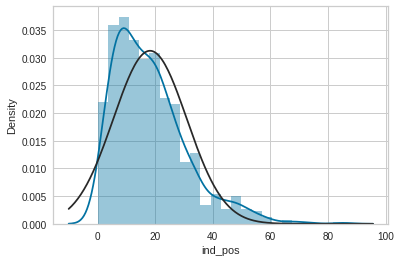

In [16]:
merged_dfs['MRNA']['ind_pos'] = (merged_dfs['MRNA']['ind_pos'])

sns.distplot(merged_dfs['MRNA']['ind_pos'], fit=norm);
plt.savefig('images/MRNA-distribution.png', transparent=True, dpi=400)

#TSLA: wted_neg, ind_neg
#XOM: wted_neg
#AAPL: wted_pos, wted_neg
#MRNA: wted_neg, wted_pos, wted_neu
#PEP

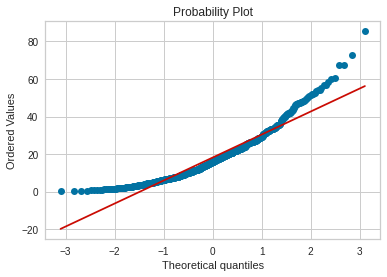

In [17]:
res = stats.probplot(merged_dfs['MRNA']['ind_pos'], plot=plt)
plt.savefig('images/MRNA-probplot.png', transparent=True, dpi=400)

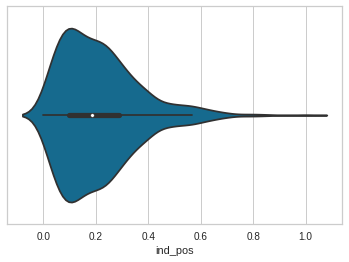

In [18]:
sns.violinplot(x='ind_pos', data=norm_dfs['MRNA'])
plt.show()

/home/vishakan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


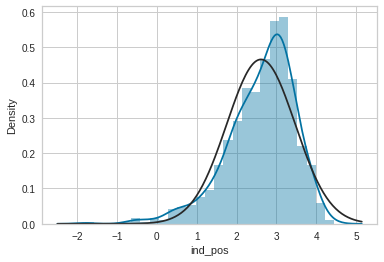

In [19]:
merged_dfs['MRNA']['ind_pos'] = np.log(merged_dfs['MRNA']['ind_pos'])

sns.distplot(merged_dfs['MRNA']['ind_pos'], fit=norm);
plt.savefig('images/MRNA-distribution-log.png', transparent=True, dpi=400)

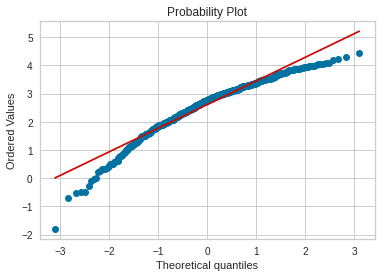

In [20]:
res = stats.probplot(merged_dfs['MRNA']['ind_pos'], plot=plt)
plt.savefig('images/MRNA-probplot-log.png', transparent=True, dpi=400)

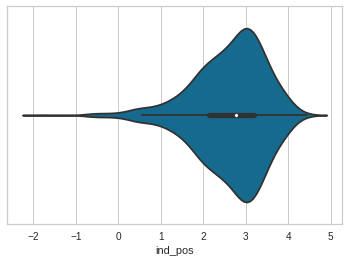

In [21]:
sns.violinplot(x='ind_pos', data=merged_dfs['MRNA'])
plt.show()

In [22]:
#norm_dfs = normalize_datasets(categories, tickers, merged_dfs, reduced = False)

/home/vishakan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='close', ylabel='Density'>

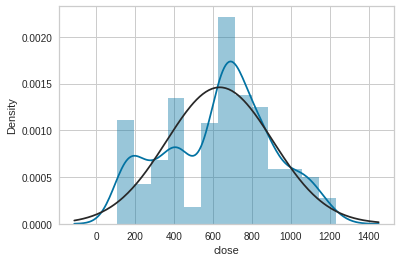

In [23]:
merged_dfs['TSLA']['close'] = (merged_dfs['TSLA']['close'])

sns.distplot(merged_dfs['TSLA']['close'], fit=norm)

#TSLA: wted_neg, ind_neg
#XOM: wted_neg
#AAPL: wted_pos, wted_neg
#MRNA: wted_neg, wted_pos, wted_neu
#PEP

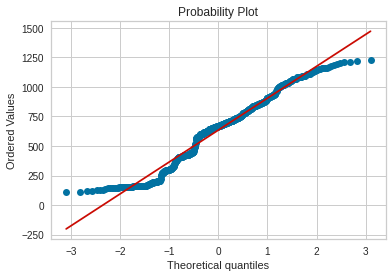

In [24]:
res = stats.probplot(merged_dfs['TSLA']['close'], plot=plt)
#plt.savefig('images/TSLA-probplot.png', transparent=True, dpi=400)

In [25]:
SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl

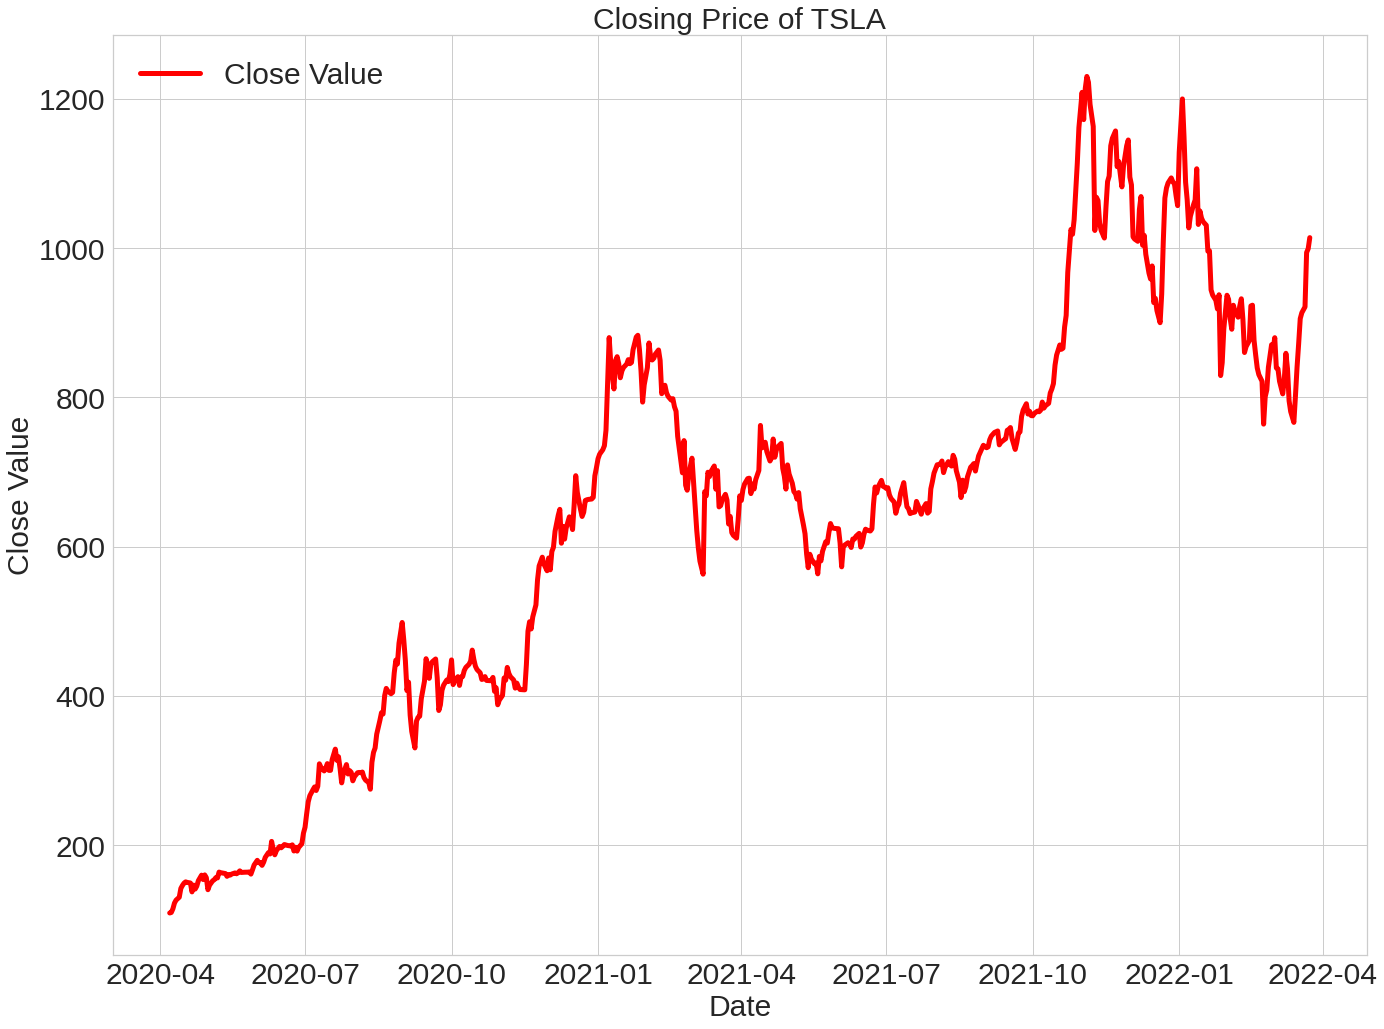

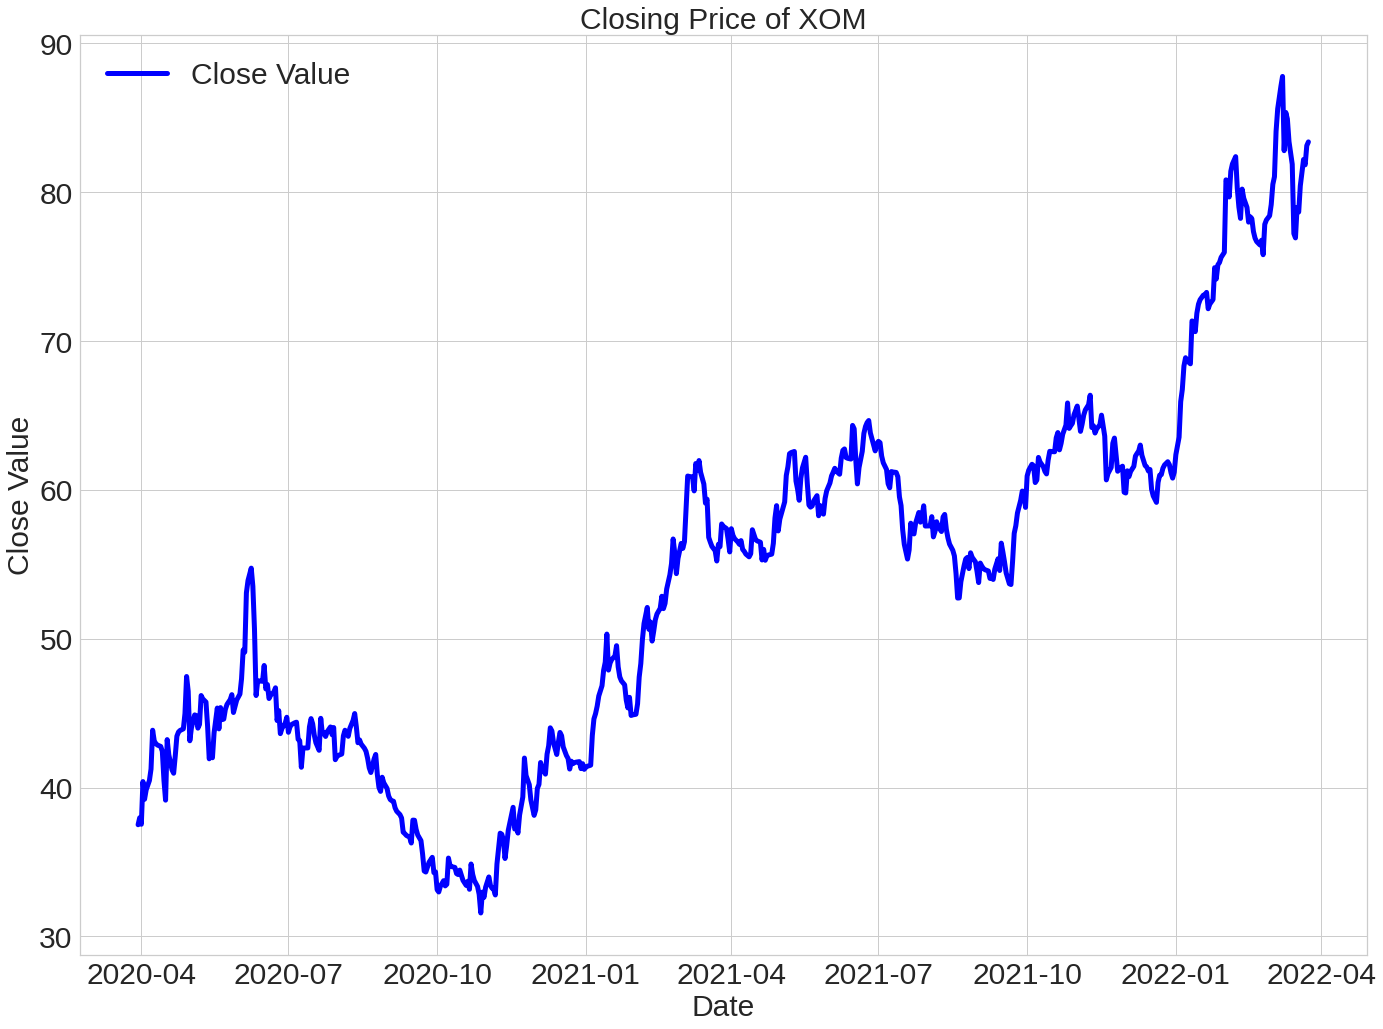

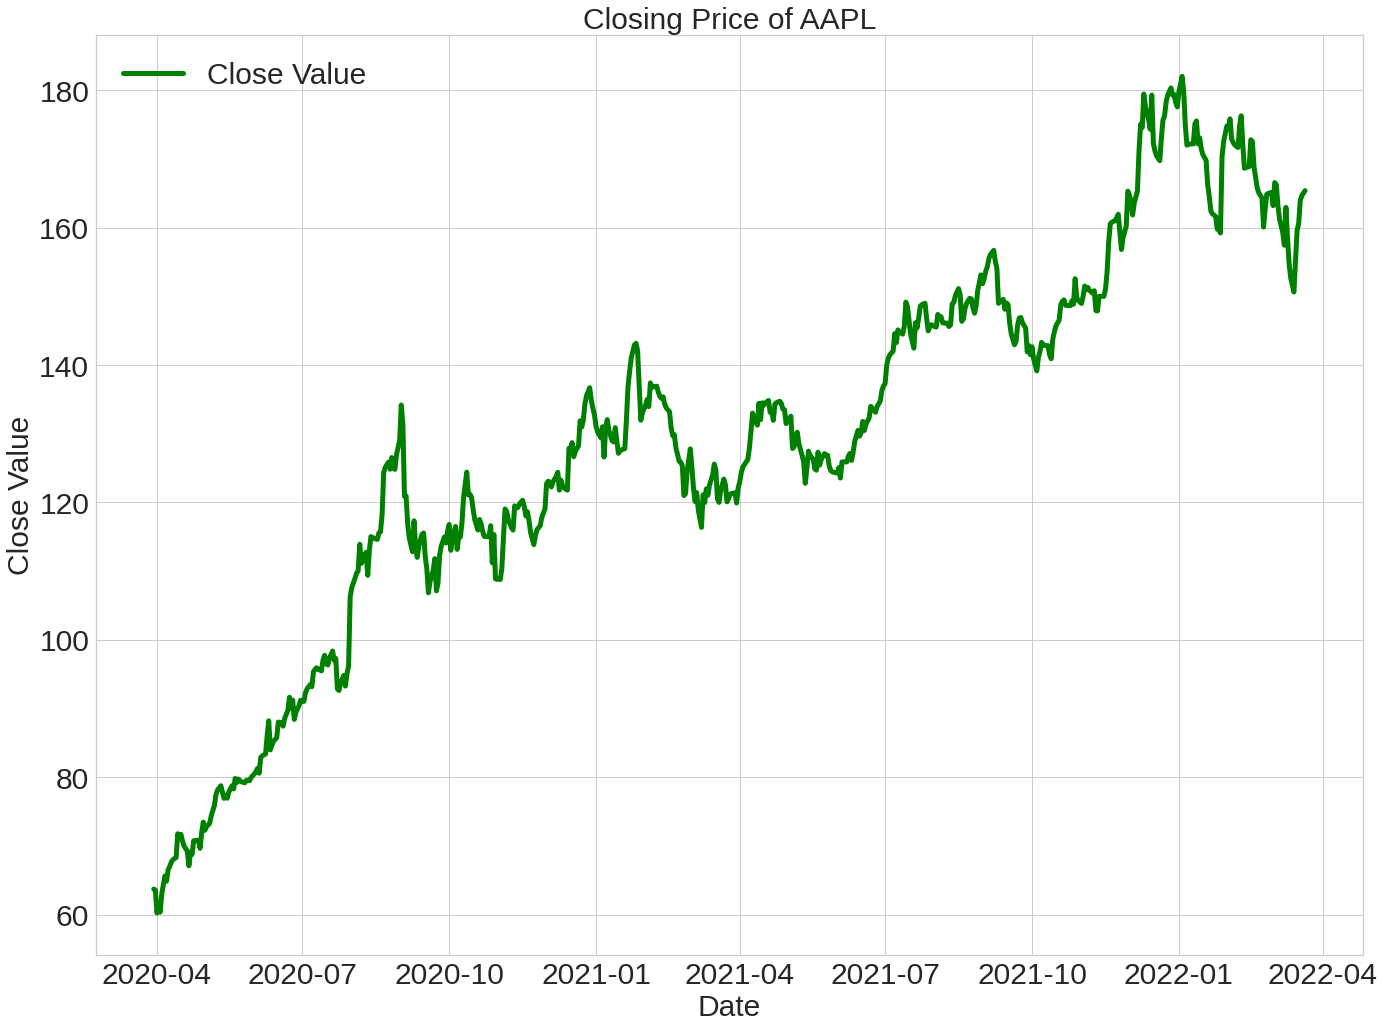

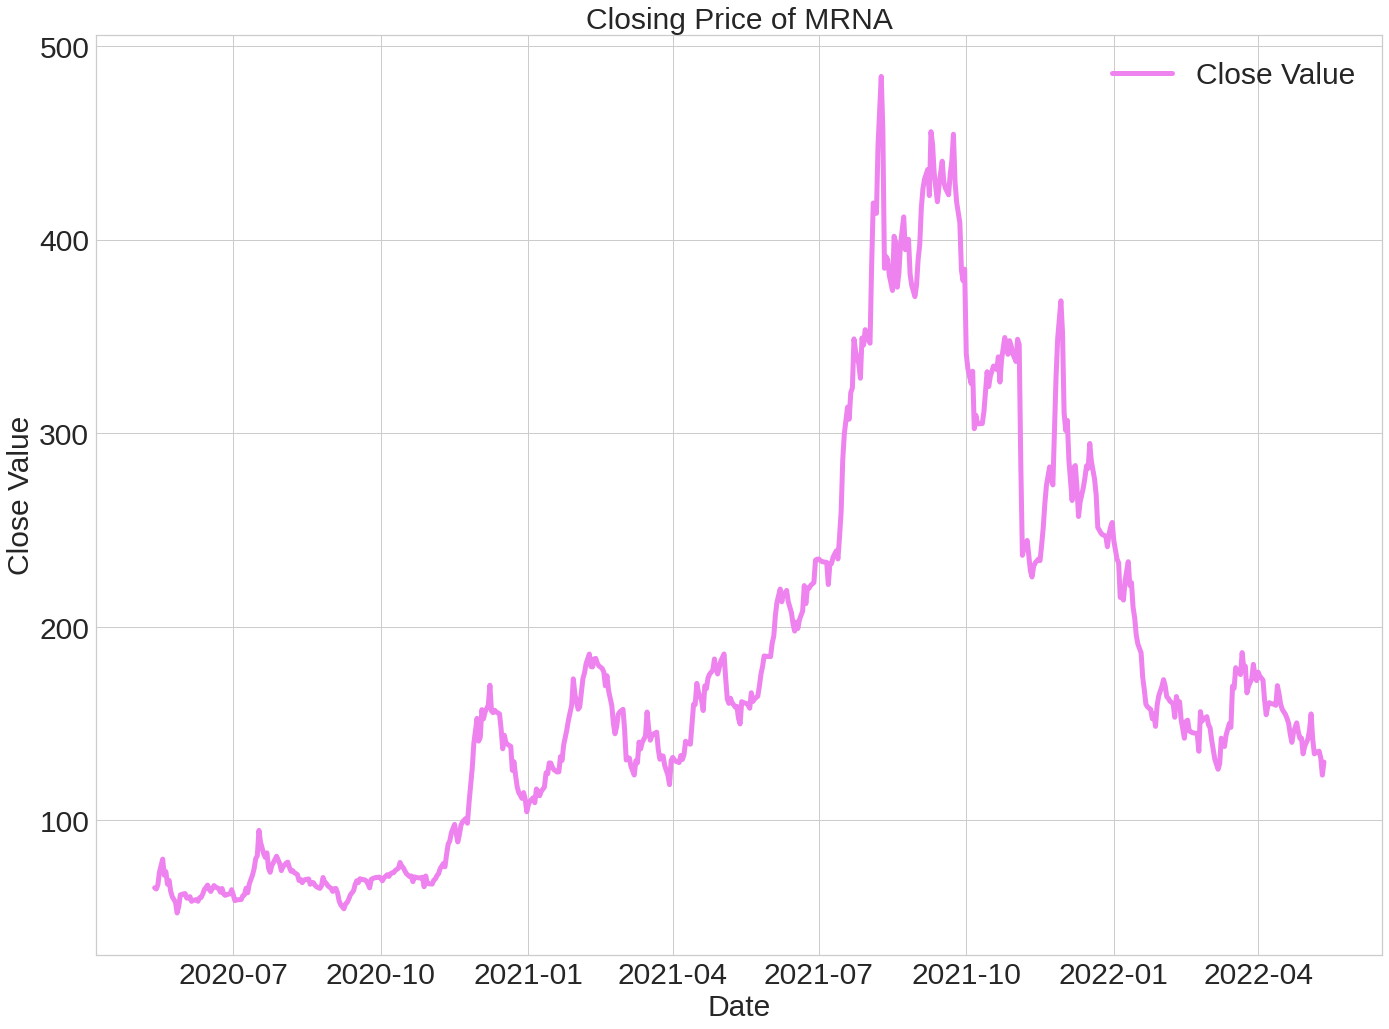

In [26]:
#plt.subplots_adjust(top=1.25, bottom=1.2)

company_list = ['TSLA', 'XOM', 'AAPL', 'MRNA']
colors = ['red', 'blue', 'green', 'violet']

for i, company in enumerate(company_list, 1):
    plt.figure(figsize=(20, 15))
    dates = merged_dfs[company]['date']
    close_vals = merged_dfs[company]['close']
    plt.plot(dates, close_vals, label='Close Value', linewidth=5, color=colors[i-1])
    
    plt.ylabel('Close Value')
    plt.xlabel('Date')
    plt.legend(loc='best')
    plt.title(f"Closing Price of {company_list[i - 1]}")
    
    plt.tight_layout()   
    plt.savefig(f'images/companies-close-{company}', transparent=True, dpi=400)
    plt.show()

In [27]:
# from pandas_profiling import ProfileReport
# ProfileReport(merged_dfs['XOM'])

In [28]:
# import phik
# from phik.report import plot_correlation_matrix
# from phik import report

# phik_overview = norm_dfs['XOM'].phik_matrix()
# phik_overview.round(2)

In [29]:
def plot_corr_heatmaps(categories, tickers, norm_dfs, save=False):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        for ticker in tickers[category]:
            plt.figure(figsize=(10,6))
            sns.heatmap(norm_dfs[ticker].corr('spearman'),cmap='RdYlGn',annot=True, linewidths=0.2)
            plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)
            if save == True and ticker in ['TSLA', 'XOM', 'AAPL', 'MRNA']:
                plt.savefig(f'images/correlation-heatmap-{ticker}', transparent=True, dpi=400)
            plt.show()

In [30]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl

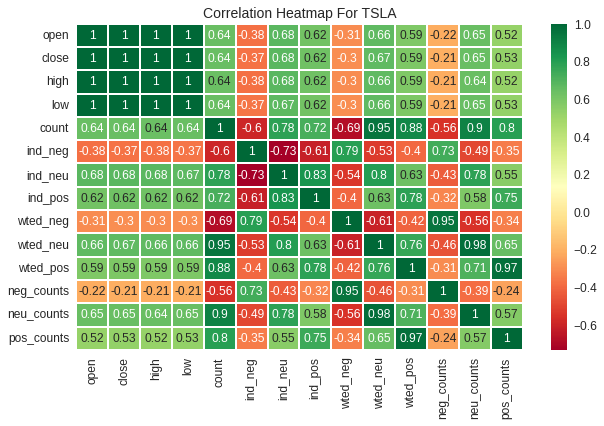

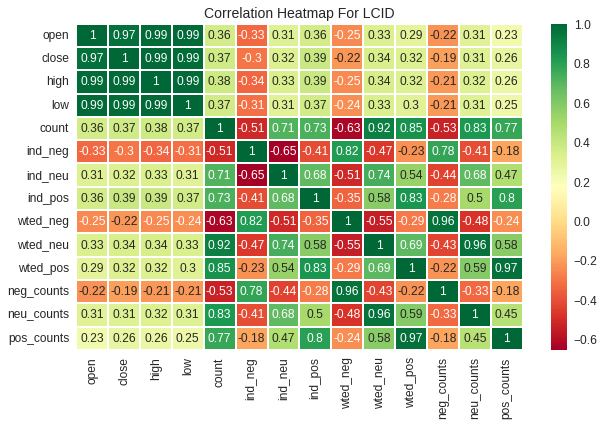

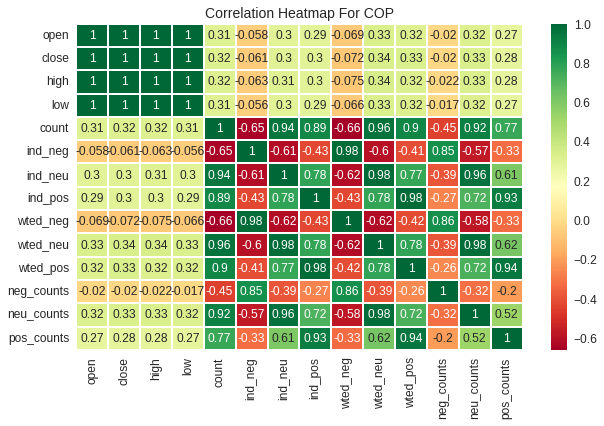

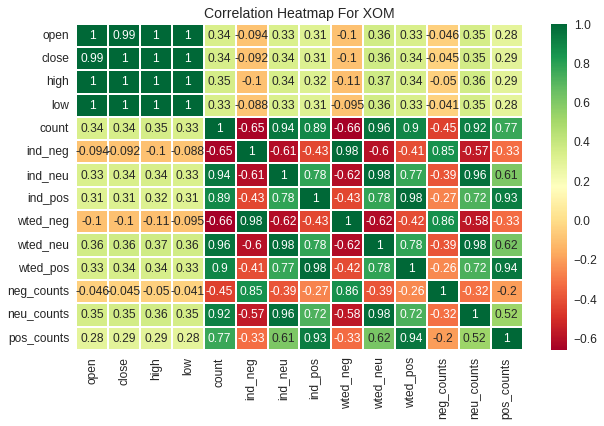

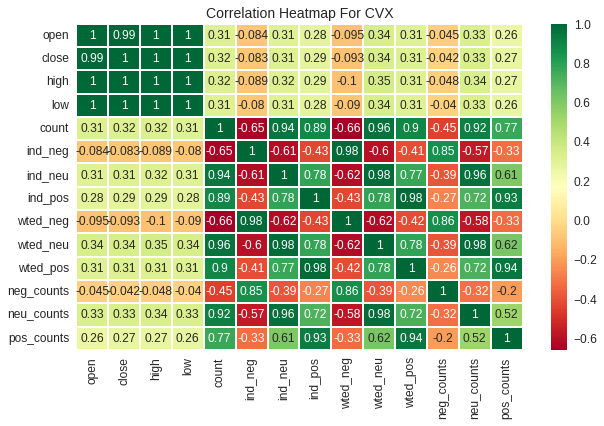

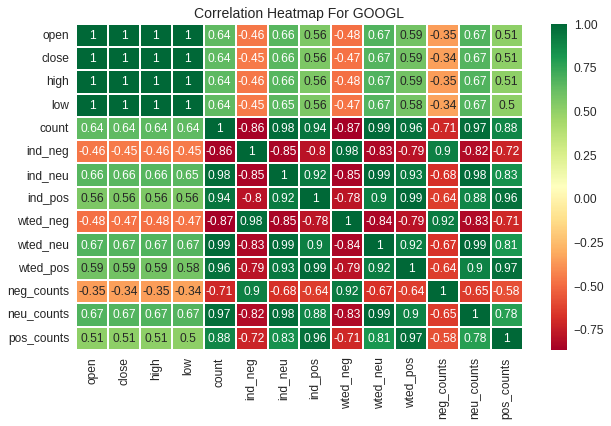

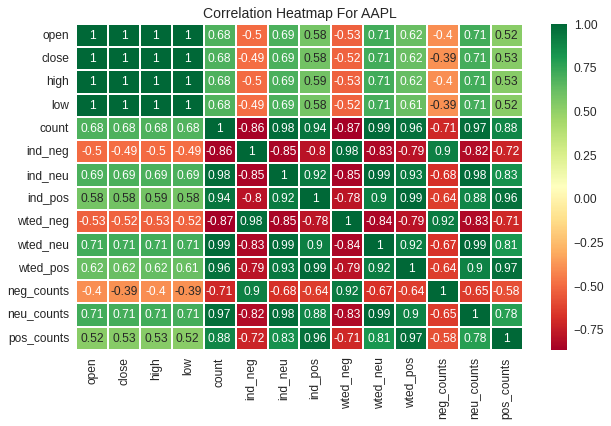

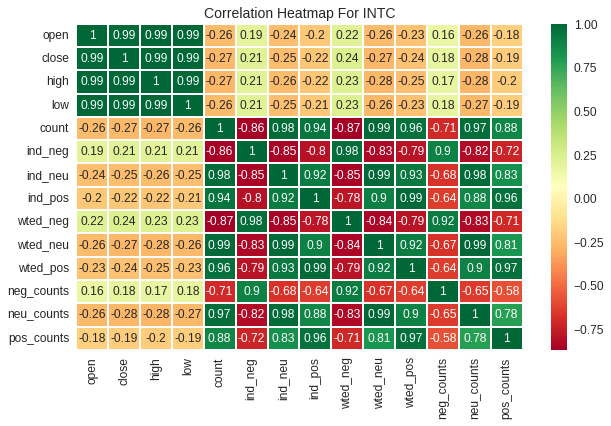

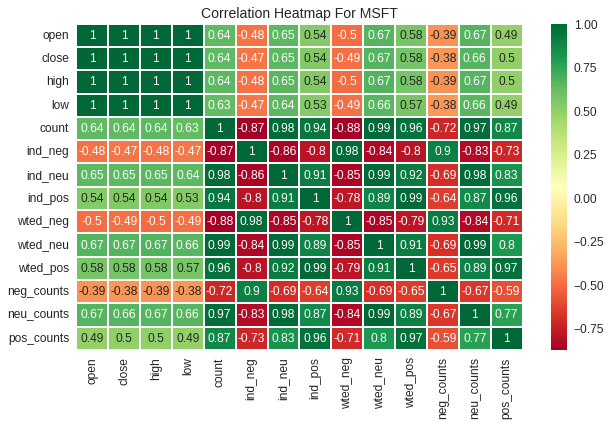

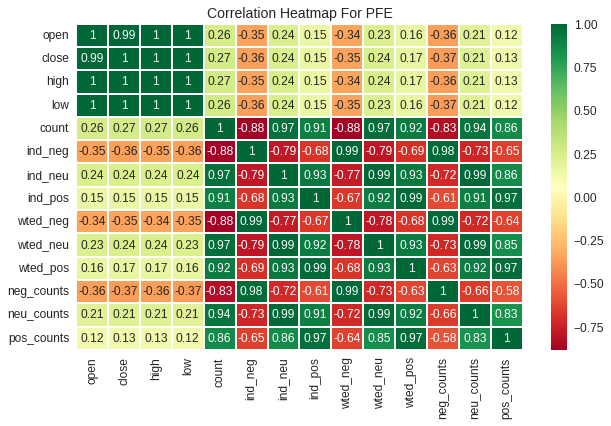

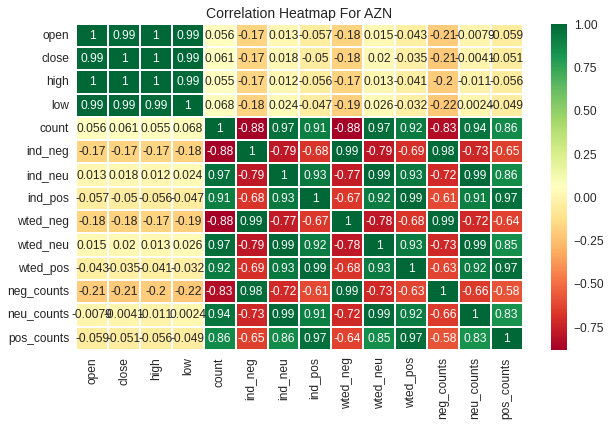

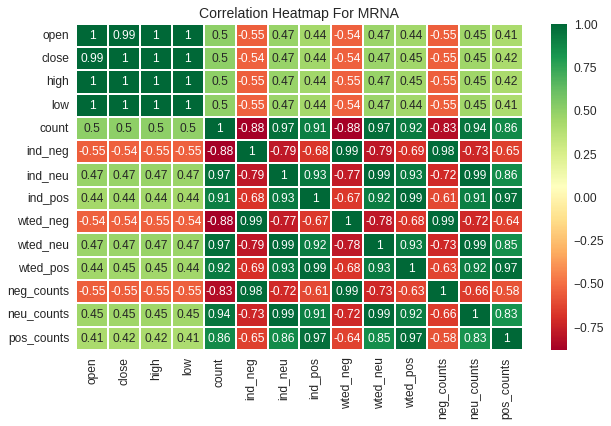

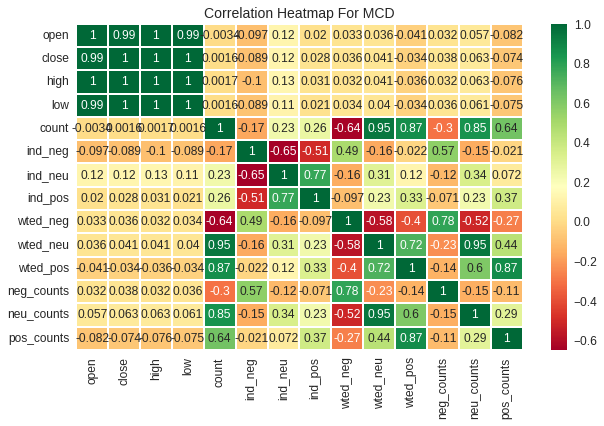

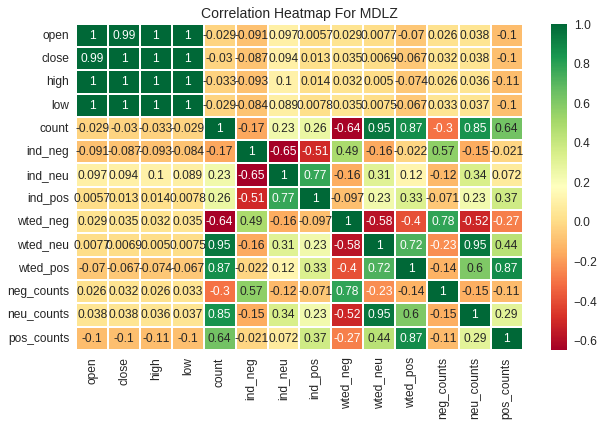

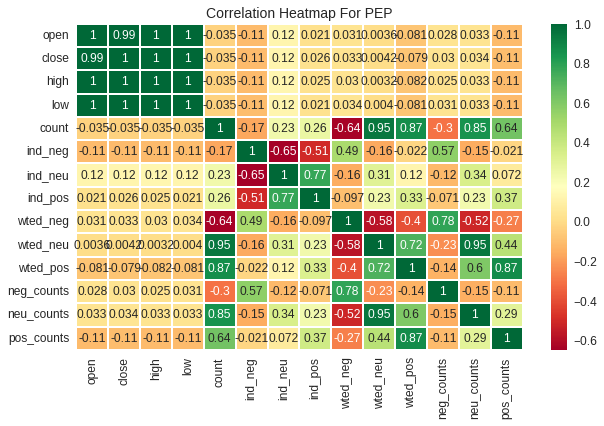

In [31]:
plot_corr_heatmaps(categories, tickers, norm_dfs, save=True)

In [32]:
#To determine the confidence levels for the correlated columns found in the correlation heatmaps

def calc_pearson_r(categories, tickers, norm_dfs):
    """
    To calculate the Pearson's correlation coefficient and determine confidence level (p > 0.05)
    """
    for category in categories:
        for ticker in tickers[category]:
            print(f"{ticker}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_neg'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_NEG - ρ: {rho}, P: {p}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_neu'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_NEU - ρ: {rho}, P: {p}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_pos'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_POS - ρ: {rho}, P: {p}")
            print("\n")
            
calc_pearson_r(categories, tickers, norm_dfs)

TSLA
	=====> IND_NEG - ρ: -0.3823323738621331, P: 2.2518611768728205e-26
	=====> IND_NEU - ρ: 0.6768830345285067, P: 3.156919513413642e-97
	=====> IND_POS - ρ: 0.6147949386004035, P: 9.370472702407569e-76


LCID
	=====> IND_NEG - ρ: -0.25304300811165237, P: 6.861831351831363e-05
	=====> IND_NEU - ρ: 0.2760508643845756, P: 1.3181543610713383e-05
	=====> IND_POS - ρ: 0.31837517094975526, P: 4.2062912725745094e-07


COP
	=====> IND_NEG - ρ: -0.07394947886710766, P: 0.04746147671681105
	=====> IND_NEU - ρ: 0.4034536600325682, P: 1.6000494594431687e-29
	=====> IND_POS - ρ: 0.3176245558627862, P: 2.5679779498572515e-18


XOM
	=====> IND_NEG - ρ: -0.07700721966729404, P: 0.03898373847222506
	=====> IND_NEU - ρ: 0.4185334927711381, P: 7.346841090324404e-32
	=====> IND_POS - ρ: 0.3375743649620593, P: 1.269770238123718e-20


CVX
	=====> IND_NEG - ρ: -0.10762616511546166, P: 0.0038612267541879284
	=====> IND_NEU - ρ: 0.4375407167762832, P: 5.558742808130398e-35
	=====> IND_POS - ρ: 0.316907020339

In [33]:
#To determine the confidence levels for the correlated columns found in the correlation heatmaps

def calc_spearman_r(categories, tickers, norm_dfs):
    """
    To calculate the Spearman's correlation coefficient and determine confidence level (p > 0.05)
    """
    for category in categories:
        for ticker in tickers[category]:
            print(f"{ticker}")
            rho, p = spearmanr(norm_dfs[ticker]['wted_neg'], norm_dfs[ticker]['close'])
            print(f"\t=====> WTED_NEG - ρ: {rho}, P: {p}")
            rho, p = spearmanr(norm_dfs[ticker]['wted_neu'], norm_dfs[ticker]['close'])
            print(f"\t=====> WTED_NEU - ρ: {rho}, P: {p}")
            rho, p = spearmanr(norm_dfs[ticker]['wted_pos'], norm_dfs[ticker]['close'])
            print(f"\t=====> WTED_POS - ρ: {rho}, P: {p}")
            print("\n")
            
calc_spearman_r(categories, tickers, norm_dfs)

TSLA
	=====> WTED_NEG - ρ: -0.2992701109543373, P: 2.6578199396151953e-16
	=====> WTED_NEU - ρ: 0.6650916957535989, P: 9.465614457598823e-93
	=====> WTED_POS - ρ: 0.5934039539052588, P: 2.0300639498504007e-69


LCID
	=====> WTED_NEG - ρ: -0.21915969773666782, P: 0.0005958229743092925
	=====> WTED_NEU - ρ: 0.3367013388084777, P: 7.948778158842208e-08
	=====> WTED_POS - ρ: 0.32077013384108427, P: 3.4042517934897235e-07


COP
	=====> WTED_NEG - ρ: -0.07166685662122721, P: 0.054755102080747624
	=====> WTED_NEU - ρ: 0.3362656715840482, P: 1.8207630472696764e-20
	=====> WTED_POS - ρ: 0.32540272444798596, P: 3.394995277394587e-19


XOM
	=====> WTED_NEG - ρ: -0.10008573016836364, P: 0.007235781157920092
	=====> WTED_NEU - ρ: 0.3640396835327077, P: 5.945041090391684e-24
	=====> WTED_POS - ρ: 0.3397295657021116, P: 6.987342861600312e-21


CVX
	=====> WTED_NEG - ρ: -0.0925935551522897, P: 0.012997501170860872
	=====> WTED_NEU - ρ: 0.3425542002117403, P: 3.1711966418711693e-21
	=====> WTED_POS - ρ

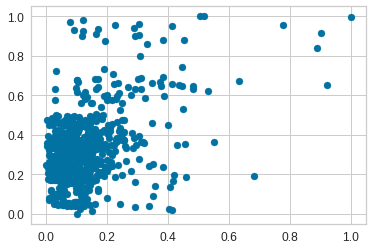

In [34]:
plt.scatter(norm_dfs["CVX"]["wted_neu"], norm_dfs["CVX"]["close"])
plt.show()

In [35]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(norm_dfs["TSLA"]["ind_neu"], norm_dfs["TSLA"]["close"], test_size=0.2, random_state=0)

X_train = X_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy().reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

reg = LinearRegression().fit(X_train, y_train)

reg.score(X_train, y_train)

0.4396178750186005

In [36]:
def add_prev_day_open(categories, tickers, merged_dfs):
    prev_open_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
    
            t_df = merged_dfs[ticker].copy(deep = True)
            t_df = t_df.drop(columns = ['high', 'low', 'count', 'ind_neg', 'ind_neu', 'ind_pos', \
                                       'neg_counts', 'neu_counts', 'pos_counts'])

            t_minus1_df = t_df.copy(deep = True).drop(columns = ['close', 'wted_neg', 'wted_neu', 'wted_pos'])

            t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

            t_df = t_df.drop(columns=['open'])

            prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

            prev_open_df = prev_open_df[['date', 'open', 'wted_neg', 'wted_neu', 'wted_pos', 'close']]

            prev_open_df = prev_open_df.rename(columns = {'open': 'prev_open'})
            
            #prev_open_df = prev_open_df.drop(columns = ['prev_open'])
            
            prev_open_dfs[ticker] = prev_open_df.copy(deep=True)
            
            del prev_open_df #Perform GC

    return prev_open_dfs

In [37]:
# def add_close_delta(categories, tickers, prev_open_dfs):
#     close_delta_dfs = dict()
    
#     for category in categories:
#         for ticker in tickers[category]:
    
#             t_df = prev_open_dfs[ticker].copy(deep = True)

#             t_minus1_df = t_df.copy(deep = True).drop(columns = ['prev_open', 'ind_neg', 'ind_neu', 'ind_pos'])
            
#             t_minus1_df = t_minus1_df.rename(columns = {'close': 'prev_close'})

#             t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

#             close_delta_df = pd.merge(t_df, t_minus1_df, on = ['date'])
            
#             close_delta_df['close_delta'] = (close_delta_df['close'] - close_delta_df['prev_close']) / close_delta_df['prev_close']

#             close_delta_df = close_delta_df[['date', 'prev_open', 'ind_neg', 'ind_neu', 'ind_pos', 'prev_close', 'close', 'close_delta']]
        
#             close_delta_dfs[ticker] = close_delta_df.copy(deep=True)
            
#             del close_delta_df #Perform GC

#     return close_delta_dfs

In [38]:
prev_open_dfs = add_prev_day_open(categories, tickers, merged_dfs)

prev_open_dfs['TSLA']

,date,prev_open,wted_neg,wted_neu,wted_pos,close
0,2020-04-08,109.0000,-64.181890,95.598511,66.219599,109.76800
1,2020-04-09,110.8400,-56.692256,94.944677,50.363070,114.60000
2,2020-04-10,112.4180,-38.086879,96.119916,84.793198,122.39500
3,2020-04-11,115.2250,-56.453269,74.535742,61.010987,126.29250
4,2020-04-12,116.6285,-32.928712,80.786284,79.285003,128.24125
...,...,...,...,...,...,...
711,2022-03-20,894.7350,-38.595751,140.025758,78.378489,917.21750
712,2022-03-21,904.8575,-41.028639,169.185808,112.785551,921.16000
713,2022-03-22,914.9800,-31.304021,173.799956,158.896021,993.98000
714,2022-03-23,930.0000,-60.719037,213.970640,187.310330,999.11000


In [39]:
# close_delta_dfs = add_close_delta(categories, tickers, prev_open_dfs)

# close_delta_dfs['PFE']

In [40]:
prev_open_norm_dfs = normalize_datasets(categories, tickers, prev_open_dfs, reduced = True)

Data dimensions for TSLA: (716, 5) 

Data dimensions for LCID: (241, 5) 

Data dimensions for COP: (712, 5) 

Data dimensions for XOM: (712, 5) 

Data dimensions for CVX: (712, 5) 

Data dimensions for GOOGL: (721, 5) 

Data dimensions for AAPL: (721, 5) 

Data dimensions for INTC: (724, 5) 

Data dimensions for MSFT: (729, 5) 

Data dimensions for PFE: (729, 5) 

Data dimensions for AZN: (729, 5) 

Data dimensions for MRNA: (729, 5) 

Data dimensions for MCD: (729, 5) 

Data dimensions for MDLZ: (729, 5) 

Data dimensions for PEP: (729, 5) 



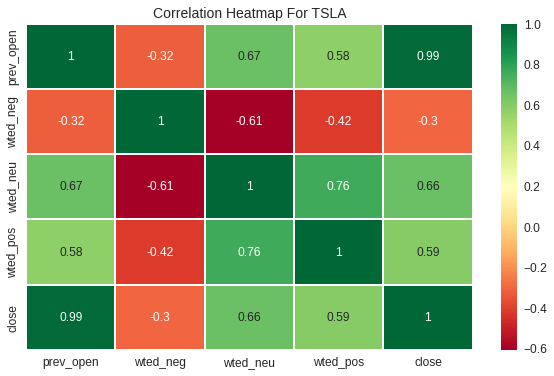

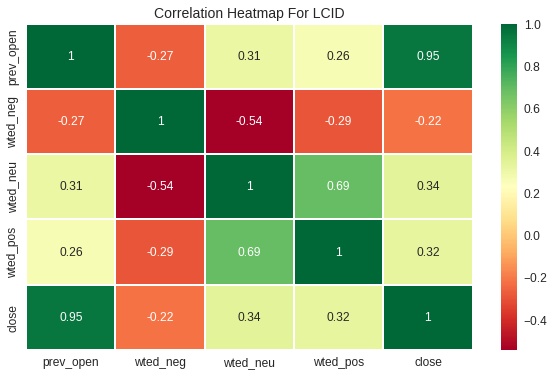

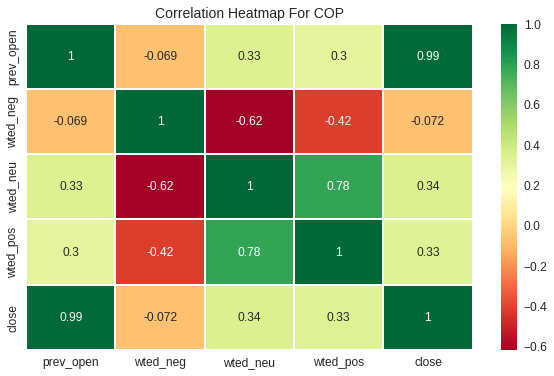

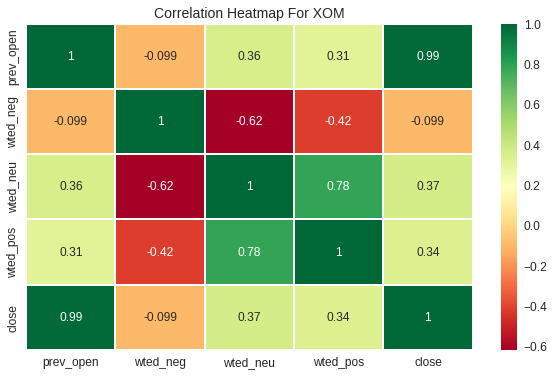

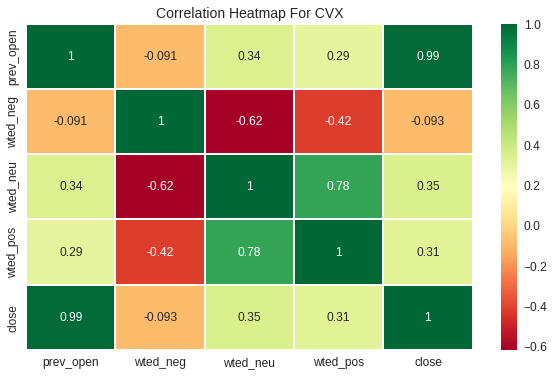

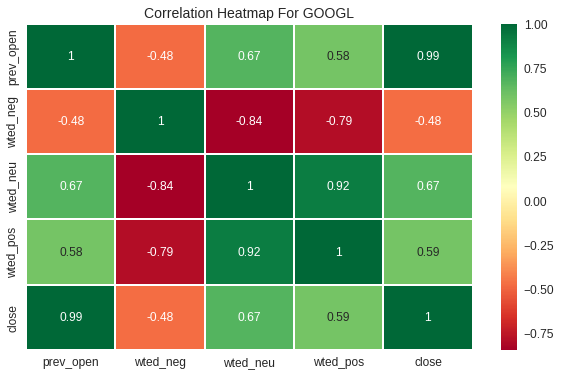

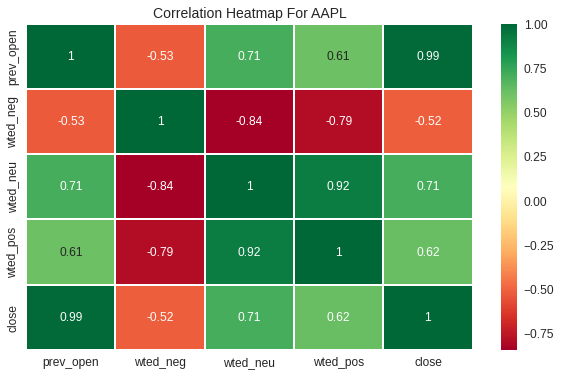

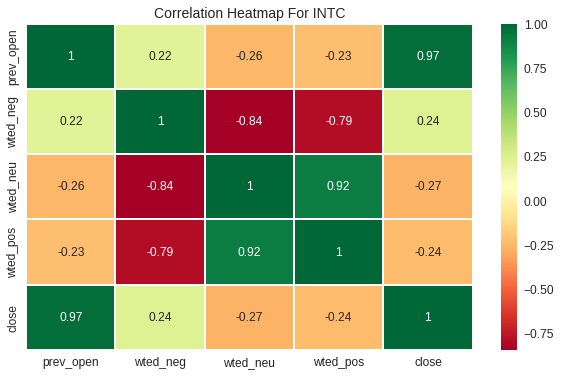

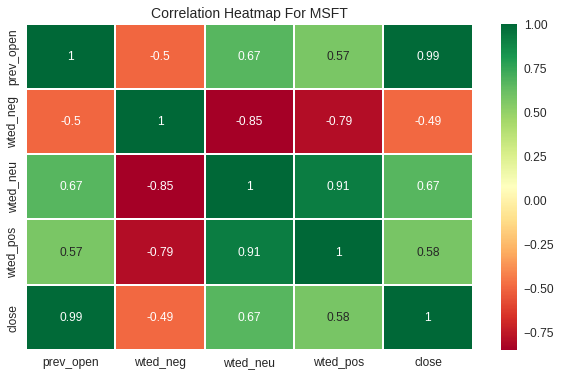

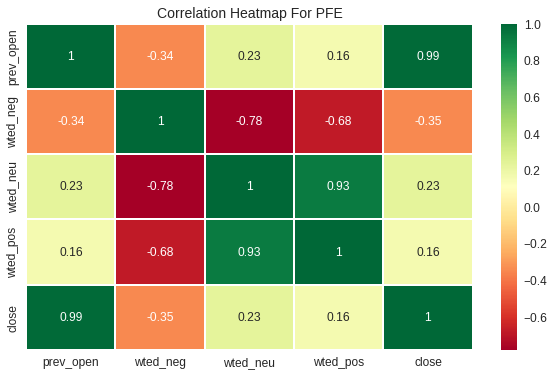

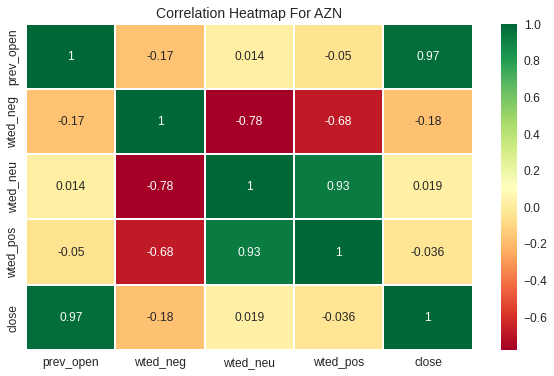

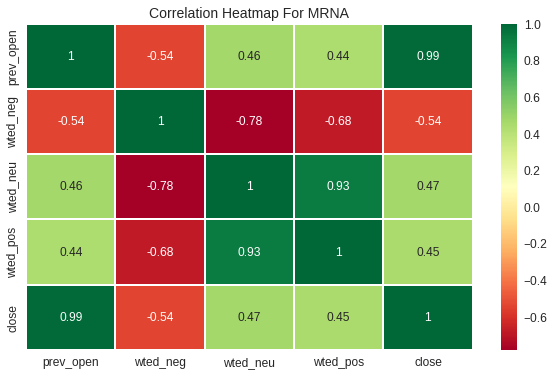

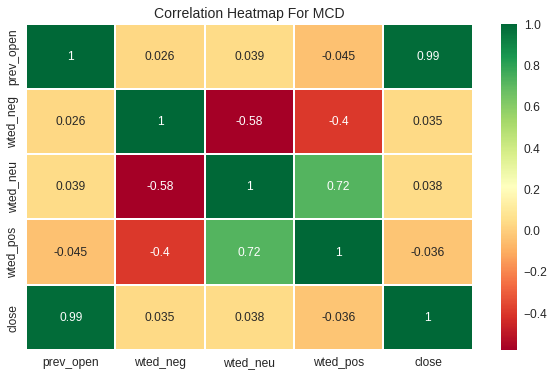

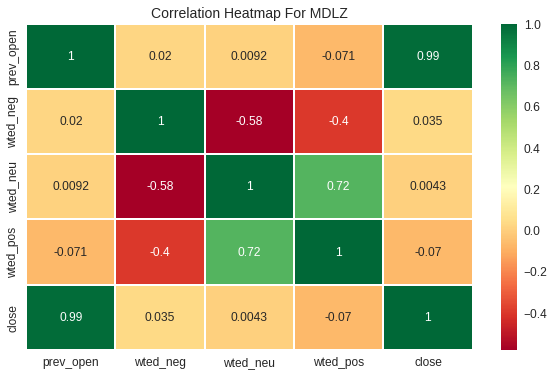

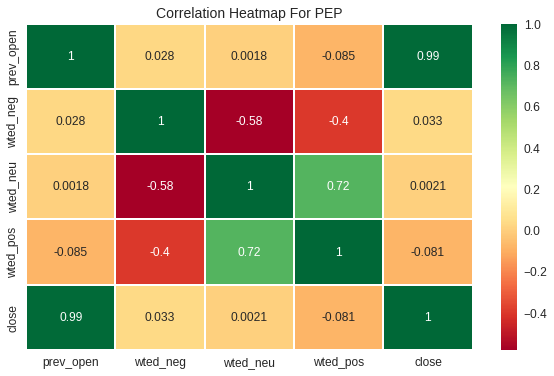

In [41]:
plot_corr_heatmaps(categories, tickers, prev_open_norm_dfs, save=False)

In [42]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [43]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    # predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [44]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.plot(predicted, color = 'green', label = 'Predicted Stock Price')
    plt.plot(test_label, color = 'red', label = 'Real Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [45]:
def get_train_test_set(norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = ['close'], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test

In [46]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [56]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels):
    
    params = {'objective': ['reg:squarederror', 'reg:squaredlogerror'],
              'eval_metric': ['mae', 'rmse', 'rmsle', 'mape'],
              'booster': ['gbtree', 'dart'],
              'max_depth': [3, 6, 8, 10, 12],
              'learning_rate': [0.005, 0.01, 0.05, 0.1],
              'n_estimators': [100, 200, 500, 1000],
              'colsample_bytree': [0.3, 0.7, 1]}


    ticker = 'AAPL'
    print(f"======CURRENTLY WORKING ON {ticker}======")
            
    X_train, X_test, y_train, y_test = get_train_test_set(norm_dfs[ticker], output_label='close')
    
    xgb_reg = XGBRegressor()
    
    xgb_grid = GridSearchCV(xgb_reg,
                        params,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

    xgb_grid.fit(X_train, y_train)
    
    print("Best Score:", xgb_grid.best_score_)
    print("\n\nBest Parameters:", xgb_grid.best_params_)
    
    #     model = XGBRegressor(max_depth=3, n_estimators=500, n_jobs=2,
#                         objective='reg:squaredlogerror', booster='dart',
#                         random_state=3, learning_rate=0.05, colsample_bytree=1, eval_metric='mae')
            
    #model.fit(X_train, y_train)
            
    #print_metrics(model, X_train, X_test, y_test)
    #plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker])
            
    print(f"======FINISHED WORKING ON {ticker}======")

In [57]:
# """ 
# ONLY ind_neg, ind_neu, ind_pos
# Best Parameters: {'booster': 'gbtree', 'colsample_bytree': 0.7, 'eval_metric': 'mae', 
# 'learning_rate': 0.005, 'max_depth': 12, 'n_estimators': 100, 'objective': 'reg:squarederror'}
# """

In [58]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, prev_open_dfs, output_label='close')

In [59]:
train_and_test_model(categories, tickers, prev_open_norm_dfs, unscaled_op_labels)

======CURRENTLY WORKING ON AAPL======
Fitting 2 folds for each of 3840 candidates, totalling 7680 fits
Best Score: -0.36704390449924645


Best Parameters: {'booster': 'gbtree', 'colsample_bytree': 1, 'eval_metric': 'mae', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'objective': 'reg:squarederror'}
======FINISHED WORKING ON AAPL======
